# Method of Moments

Master equations are simply system of differential equations, but they can become prohibitively large since they track the exact state of a system. Think for example of a mixture of chemicals where the number of molecules of a given compound can vary by $10^{23}$ orders of magnitude or more. Writing a differential equation for the occupation number of each state is easy, but impossible to implement and use. 

Ultimately, the goal of master equations is to track the distribution of possible states. When the support of that distribution becomes too large, we might just want to capture features of that distribution rather than its exact value on every state. This is the goal of the **method of moments** (MoM), an approach which generates mean-field models tracking the evolution of the moments of the state distribution rather than every exact occupation number.

Consider the following relationship between occupation numbers $\lbrace P_n(t) \rbrace$ at time $t$ and the average state $\langle n(t) \rangle$ typically tracked by mean-field models:

$$
\sum_n n\frac{d}{dt} P_n(t) = \frac{d}{dt}\sum_n n P_n(t) = \frac{d}{dt}\langle n(t) \rangle
$$

The left hand side is a simple sum over $n$ of the product of $n$ with the master equation described in previous section. Through the middle transformation however, we realize how this simple sum produces a single differential equation tracking the dynamics of the average state of the system over time, $\langle n(t) \rangle$.

This approach generalizes like so.

$$
\sum_n n^k\frac{d}{dt} P_n(t) = \frac{d}{dt}\sum_n n^k P_n(t) = \frac{d}{dt}\langle n^k(t) \rangle
$$

And we therefore have a simple tool (a sum of master equations) which lets us generate mean-field models for the different moments of the state distribution! This is infinitely useful when the master equation of the system is simple but defined over too many states to be numerically tractable. 

## MoM of the average birth-death process

Consider the [birth–death process](https://en.wikipedia.org/wiki/Birth%E2%80%93death_process) with a fixed constant birth rate $\mu$ for particles and a fixed death rate $\nu$ for all active particles. For this process, our master equation is

$$
\frac{d}{dt}P_n(t) = -(\mu + n\nu)P_n(t) + (n+1)\nu P_{n+1}(t) + \mu P_{n-1}(t)
$$

where $P_{n<0}(t) = 0$ for all times. We can apply the MoM to extract a differential equation for $\langle n(t) \rangle$:

$$
\frac{d}{dt} \langle n(t) \rangle = \sum_n n \frac{d}{dt}P_n(t) = \sum_n -n\mu P_n(t) - n^2\nu P_n(t) + n(n+1)\nu P_{n+1}(t) + n \mu P_{n-1}(t)
$$

The goal is then to apply the sums to simplify the expression. A useful way to first look at these problems is through brute force, finding that for $n=0$ the four terms above are all zero, then $-\mu P_1(t) -\nu P_1(t) + 2\nu P_2(t) +_ \mu P_0(t)$ for $n=1$ and so on. We can eventually notice that the terms in $\mu$ can be summed explicitly and that the two terms in $\nu$ can be combined. We then find

$$
\frac{d}{dt} \langle n(t) \rangle = -\mu \langle n(t) \rangle -\nu \langle n(t) \rangle + \mu(\langle n(t) \rangle+1) = \mu - \nu\langle n(t) \rangle
$$

What incredible magic! The MoM has produced the exact coarse-grained mean-field equation we would have written down from a simple compartmental approach tracking the average number of particles in the system! The compartment $n(t)$ has a linear input at rate $\mu$, and a proportional output of particles at rate $\nu n(t)$.

Starting in the inactive state, $P_0(0) = 1$ and $\langle n(t) \rangle = 0$, this differential equation for $\langle n(t) \rangle$ yields $\langle n(t) \rangle = \frac{\mu}{\nu} \left(1 - e^{-\nu t}\right)$.

## MoM for a birth-death variance

We apply the MoM to obtain a differential equation for the dynamics of the second moment of the birth-death process over time:

$$
\frac{d}{dt} \langle n^2(t) \rangle = \sum_n n^2 \frac{d}{dt}P_n(t) = \sum_n -n^2\mu P_n(t) - n^3\nu P_n(t) + n^2(n+1)\nu P_{n+1}(t) + n^2 \mu P_{n-1}(t)
$$

Doing the sums explicitly (fun exercise!) we get

$$
\frac{d}{dt} \langle n^2(t) \rangle = \mu(2\langle n(t) \rangle+1)+ \nu (\langle n(t) \rangle - 2\langle n^2(t)\rangle)
$$

This equation can be paired with the previous one to give us a 2-dimensional system tracking the average ($\langle n(t) \rangle$) and variance ($\langle n^2(t) \rangle - \langle n(t) \rangle^2$) through time. Powerful stuff!

:::{seealso}
In general, there is no guarantee that the method of moments will produce differential equations that do not depend on higher moments. For example, what if a term in $n^3$ remained in the last equation? Of course, we could then use the same method to generate a differential equation for $\langle n^3(t)\rangle$ and gain precision. But what if that one then depends on $n^4$? This is where [moment closure](https://en.wikipedia.org/wiki/Moment_closure) comes in to save the day! In those cases, we can make some assumptions about the shape of the state distributions and estimate the unknown higher moments, like $\langle n^3(t)\rangle$, in terms of known lower moments, $\langle n(t)\rangle$ and $\langle n^2(t)\rangle$. Assuming the right distribution and getting a good approximation for the moment closure is an art. It is always interesting to play around with different approximation in cases where we can compare with numerical integrations (for example using a smaller system).
:::

## Comparison with numerical integration

/var/folders/qs/h2k9jxts0n34jj1zq8z7dvtw0000gn/T/ipykernel_56387/800385317.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['ggplot', 'seaborn-talk'])


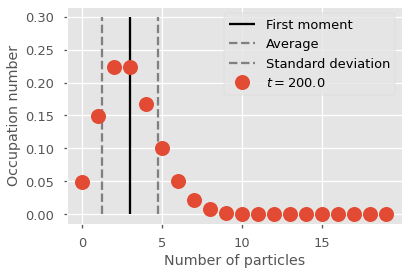

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['ggplot', 'seaborn-talk'])

# We will use the odeint routine
from scipy.integrate import odeint

# Master Equations
def J(x, t, mu, nu):    
    dx = 0*x
    for n in range(len(x)):
        if n==0: #for first state
            dx[0] = - mu*x[0] + nu*x[1]
        elif n==len(x)-1: #for last state
            dx[n] = -(nu*n)*x[n] + mu*x[n-1]
        else: #all other states
            dx[n] = -(mu+nu*n)*x[n] + nu*(n+1)*x[n+1] + mu*x[n-1]

    return dx

#MoM
def MOM(x, t, mu, nu):     
    dx = 0*x
    dx[0] = mu - nu*x[0]
    dx[1] = mu*(2*x[0]+1) + nu*(x[0]-2*x[1])
    return dx

# Time of observations
t_length = 200
t_steps = 10
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 20
x_0 = np.zeros(nb_of_states)
x_0[0] = 1
m_0 = np.zeros(2)

# Parameters
mu = 0.3
nu = 0.1

# Numerical integration
G = lambda x, t: J(x, t, mu, nu)
M = lambda m, t: MOM(m, t, mu, nu)
x_path = odeint(G, x_0, t_vec)
m_path = odeint(M, m_0, t_vec)

stddev = np.sqrt(m_path[-1][1]-m_path[-1][0]**2)

# Plot
plt.vlines(m_path[-1][0], 0, 0.3, colors='black', linestyles='-', label='First moment')
plt.vlines(m_path[-1][0]+stddev, 0, 0.3, colors='gray', linestyles='--', label='Average')
plt.vlines(m_path[-1][0]-stddev, 0, 0.3, colors='gray', linestyles='--', label='Standard deviation')
plt.plot(range(nb_of_states),x_path[-1], marker="o", lw=0, ms=15, label=fr"$t = {t_vec[-1]}$")
plt.legend()
plt.ylabel('Occupation number')
plt.xlabel('Number of particles')
plt.show()

We can also compare the moments directly to the moments of the integrated state distribution to validate the Method of Moments. Make no mistake: Without moment closures, the method of moments is not an approximation but an exact coarse-graining of master equations into a simpler system tracking the moments of the occupation number.

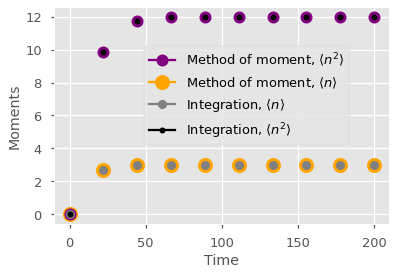

In [28]:
# Plot
for t in range(t_steps-1):
    plt.plot(t_vec[t],m_path[t][0], marker="o", color='orange', markersize = 15)
    plt.plot(t_vec[t],m_path[t][1], marker="o", color='purple', markersize = 12)
    plt.plot(t_vec[t],np.sum(np.arange(0,nb_of_states)*x_path[t]), marker="o", color='gray')
    plt.plot(t_vec[t],np.sum(np.arange(0,nb_of_states)*np.arange(0,nb_of_states)*x_path[t]), marker="o", markersize = 6, color='k')
# Last points and labels    
plt.plot(t_vec[-1],m_path[-1][1], marker="o", color='purple', markersize = 12, label=r'Method of moment, $\langle n^2 \rangle$')
plt.plot(t_vec[-1],m_path[-1][0], marker="o", color='orange', markersize = 15, label=r'Method of moment, $\langle n \rangle$')
plt.plot(t_vec[-1],np.sum(np.arange(0,nb_of_states)*x_path[-1]), marker="o", color='gray',label=r'Integration, $\langle n \rangle$')
plt.plot(t_vec[-1],np.sum(np.arange(0,nb_of_states)*np.arange(0,nb_of_states)*x_path[-1]), marker="o", markersize = 6, color='k',label=r'Integration, $\langle n^2 \rangle$')
plt.legend(bbox_to_anchor=[0.9, 0.85])
plt.ylabel('Moments')
plt.xlabel('Time')
plt.show()

## MoM for multi-dimensional systems

[Predator-prey dynamics with Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) are one of the most common model of complex systems in more than two dimensions. Here, we will assume (1) that prey (fish) reproduce exponentially based on a rate $\alpha$; (2) that any predator can come into contact and eat any prey at a given rate $\beta$ allowing them to reproduce; and (3) that predator die of old age at a rate $\gamma$. Following our usual recipe, one can construct the following master equation.

$$
\begin{align}
\frac{d}{dt}P_{n_1,n_2}(t) &= -\alpha n_1P_{n_1,n_2}(t) - \gamma n_2 P_{n_1,n_2}(t) - \beta n_1 n_2 P_{n_1,n_2}(t) \\
& + \alpha (n_1-1)P_{n_1-1,n_2}(t) + \gamma (n_2+1) P_{n_1,n_2+2}(t) + \beta (n_1+1)(n_2-1) P_{n_1+1,n_2-1}(t)
\end{align}
$$

Fun model! But without a clear carrying capacity for the environment, this dynamical system can easily produce very large populations of predators and prey. Even just allowing them both to vary between extinction and 1000, yield $1000 \times 1000 = 1,000,000$ states to track. MoM to the rescue!

In two dimensions, the method of moments generalizes in the following way. The first moments (note the plural) are tracked like so.

$$
\begin{align}
\sum_{n_1} \sum_{n_2} n_1\frac{d}{dt} P_{n_1,n_2}(t) & = \frac{d}{dt}\langle n_1(t) \rangle \\
\sum_{n_1} \sum_{n_2} n_2\frac{d}{dt} P_{n_1,n_2}(t) & = \frac{d}{dt}\langle n_2(t) \rangle
\end{align}
$$

While higher moments need to consider all possible combinations of variables:

$$
\begin{align}
\sum_{n_1} \sum_{n_2} n_1^2\frac{d}{dt} P_{n_1,n_2}(t) & = \frac{d}{dt}\langle n_1^2(t) \rangle \\
\sum_{n_1} \sum_{n_2} n_1n_2\frac{d}{dt} P_{n_1,n_2}(t) & = \frac{d}{dt}\langle n_1n_2(t) \rangle \\
\sum_{n_1} \sum_{n_2} n_2^2\frac{d}{dt} P_{n_1,n_2}(t) & = \frac{d}{dt}\langle n_2^2(t) \rangle
\end{align}
$$

Following the method as above, we can coarse-grain the Lotka-Volterra master equation to the following first-order moments:

$$
\begin{align}
\frac{d}{dt}\langle n_1(t) \rangle & = \alpha \langle n_1(t) \rangle - \beta \langle n_1(t) n_2(t)\rangle \\
\frac{d}{dt}\langle n_2(t) \rangle & = \beta \langle n_1(t) n_2(t)\rangle - \gamma \beta \langle n_2(t)\rangle
\end{align}
$$

Uh oh! Our first-order equations depend on the second moment $\langle n_1(t) n_2(t)\rangle$. As discussed above, this is where [moment closure](https://en.wikipedia.org/wiki/Moment_closure) comes in to save the day! We need to make some educated guess or assumptions in order to approximate the higher unknown moment $\langle n_1(t) n_2(t)\rangle$ using the lower known moments $\langle n_1(t) \rangle$ and $\langle n_2(t)\rangle$. We could attempt to be fancy and guess the form of potential correlations between the predator and prey populations... or we can simply assume that they are independent.

Assuming independence of populations, we would get $\langle n_1(t) n_2(t)\rangle = \langle n_1(t) \rangle \langle n_2(t) \rangle$. Leading to the following close system of equations for the first moments of the Lotka-Volterra model:

$$
\begin{align}
\frac{d}{dt}\langle n_1(t) \rangle & = \alpha \langle n_1(t) \rangle - \beta \langle n_1(t)\rangle \langle  n_2(t)\rangle \\
\frac{d}{dt}\langle n_2(t) \rangle & = \beta \langle n_1(t)\rangle \langle n_2(t)\rangle - \gamma \beta \langle n_2(t)\rangle
\end{align}
$$

Again, MoM's recipe leads to a classic model which could have been derived using a classic compartmental approach. However, the method of moments can also be used to generate a counter-intuitive 5-dimensional system for the first five moments of the Lotka-Volterra model. How else could one track the variance in a complex systems like that? MoM's magic!